<a href="https://colab.research.google.com/github/tokelau/MIPT/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Изучение датасетов об успеваемости студентов на онлайн-курсе

# train.csv - успеваемость студентов

- **timestamp:** (int64) время между этим действием и первым завершением события(?) от этого пользователя
- **user_id:** (int32) ID code for the user.
- **content_id:** (int16) ID активности
- **content_type_id:** (int8) 0, если это задание/вопрос, 1, если это лекция
- **task_container_id:** (int16) Идентификационный код для пакета вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидит пояснения к любому из них. Все эти трое будут иметь общий идентификатор task_container_id.
- **user_answer:** (int8) ответ пользователя. -1, если это была лекция
- **answered_correctly:** (int8) 1 - ответ верный, 0 - неверный, -1 - это была лекция
- **prior_question_elapsed_time:** (float32) Среднее время в миллисекундах, затрачиваемое пользователем на ответ на каждый вопрос из предыдущей группы вопросов, без учета промежуточных лекций. Имеет значение null для первого набора вопросов пользователя или лекции. Обратите внимание, что время — это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем наборе.
- **prior_question_had_explanation**: (bool) предыдущий вопрос имел объяснение(?) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [ ]:
train = pd.read_csv("riiid-test-answer-prediction/train.csv", index_col="row_id") # , nrows=20000

In [ ]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       20000 non-null  int64  
 1   user_id                         20000 non-null  int64  
 2   content_id                      20000 non-null  int64  
 3   content_type_id                 20000 non-null  int64  
 4   task_container_id               20000 non-null  int64  
 5   user_answer                     20000 non-null  int64  
 6   answered_correctly              20000 non-null  int64  
 7   prior_question_elapsed_time     19542 non-null  float64
 8   prior_question_had_explanation  19957 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 1.5+ MB


In [ ]:
train.describe()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,2.000000e+04,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,19542.000000
mean,5.707366e+09,90272.814350,5416.631600,0.02075,1158.101250,1.390850,0.649900,24261.523744
std,5.151766e+09,69644.353597,4025.878106,0.14255,1265.240323,1.196728,0.518694,15499.427882
min,0.000000e+00,115.000000,0.000000,0.00000,0.000000,-1.000000,-1.000000,333.000000
25%,1.535160e+09,24418.000000,2081.000000,0.00000,251.000000,0.000000,0.000000,16000.000000
50%,4.578822e+09,91216.000000,5263.000000,0.00000,715.000000,1.000000,1.000000,21000.000000
75%,8.577729e+09,141455.000000,7744.250000,0.00000,1405.250000,3.000000,1.000000,28000.000000
max,4.375822e+10,220268.000000,32736.000000,1.00000,4889.000000,3.000000,1.000000,300000.000000


### Сколько студентов?

In [ ]:
len(train['user_id'].unique()) # всего данные собраны от 393656 студентах

393656

### Процент лекций и задач

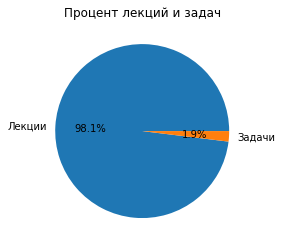

In [ ]:
_ = train['content_type_id'].value_counts().plot.pie(autopct='%1.1f%%', title='Процент лекций и задач',
                                                labels=["Лекции", "Задачи"], ylabel="")

Подавляющее большинство записей о задачах

### Процент правильных ответов

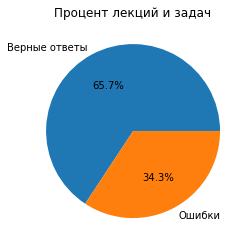

In [ ]:
_ = train[train['answered_correctly'] != -1]['answered_correctly'].value_counts().plot.pie(autopct='%1.1f%%', title='Процент лекций и задач',
                                                labels=["Верные ответы", "Ошибки"], ylabel="")

Две трети ответов были верными. Посмотрим, как этот показатель будет менятьья в зависимости от разных параметров

### Время

1. Посмотрим частотное распределение времени между действием и первым завершением события

<AxesSubplot:>

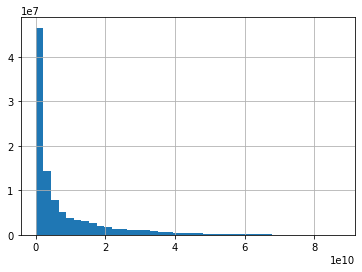

In [ ]:
train['timestamp'].hist(bins=40) 

Есть единичные случаи реагирования > 2 * 10^10 мс. В основном значения до 2*10^10 мс, что примерно равно 33 недели или 231 день. Большая часть данных лежит в 25% процентиле 

2. Посмотрим частотное распределение времени, затрачиваемого на решение каждого вопроса  из предыдущей группы вопросов, без учета промежуточных лекций. Исключим null

<AxesSubplot:>

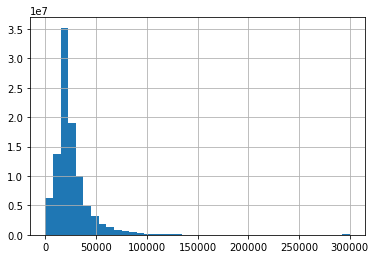

In [ ]:
train['prior_question_elapsed_time'].dropna().hist(bins=40) 

Здесь уже что-то похожее на скошенное нормальное распределение. Вероятно, из-за того, что студенты задумывались над ответами. И порядок данных совсем другой, большинство до 100 000 мс, что примерно 100 секунд и 1,6 минут

## Гипотеза 1. 
Время, которое студенты тратят на ответ взаимосвязано с правильностью ответа. Построим нормированную гистограмму

Text(0.5, 1.0, 'Ошибочные ответы')

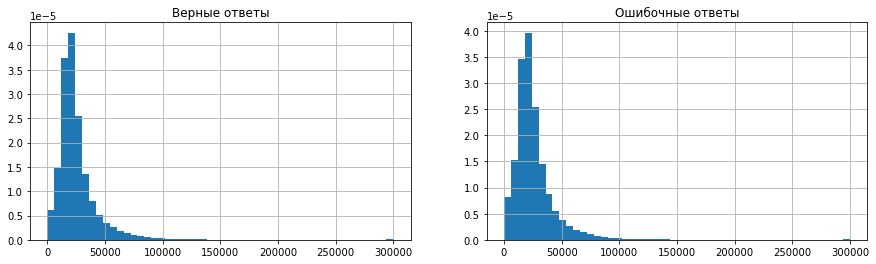

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

train[train['answered_correctly'] == 1]['prior_question_elapsed_time'].dropna().hist(bins=50, 
                                                                                     density=True, 
                                                                                     ax=ax[0])
train[train['answered_correctly'] == 0]['prior_question_elapsed_time'].dropna().hist(bins=50, 
                                                                                     density=True, 
                                                                                     ax=ax[1]) 

ax[0].set_title("Верные ответы")
ax[1].set_title("Ошибочные ответы")

Распределения похожи, но пик распределения с верными ответами превышает 4*10^-5, чего нельзя сказать о распределении с ошибочными ответами. Вероятно, над правильными ответами чаще думали дольше. Посмотрим средние:

In [ ]:
pd.DataFrame({"Верные":
                train[train['answered_correctly'] == 1]['prior_question_elapsed_time'].dropna().agg(['mean', 'median']),
              "Ошибочные":
                train[train['answered_correctly'] == 0]['prior_question_elapsed_time'].dropna().agg(['mean', 'median'])
             })

,Верные,Ошибочные
mean,25309.977185,25641.991586
median,21000.000000,21000.000000


Медианы совпадают, среднее время правильных ответов меньше, чем неправильных. Требутеся более глубокий анализ

## Гипотеза 2. 
Время между действием и первым завершением события имеет зависимость с правильностью ответа

Text(0.5, 1.0, 'Ошибочные ответы')

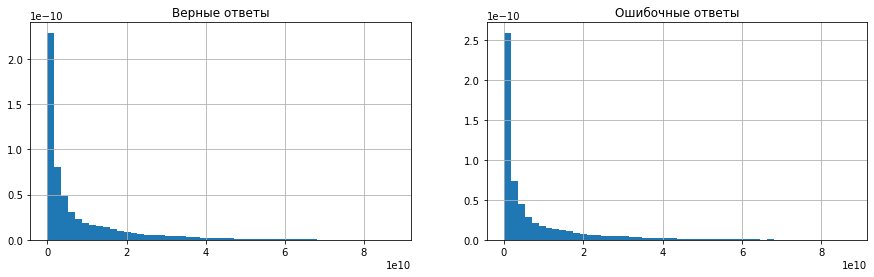

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

train[train['answered_correctly'] == 1]['timestamp'].dropna().hist(bins=50, 
                                                                   density=True, 
                                                                   ax=ax[0])
train[train['answered_correctly'] == 0]['timestamp'].dropna().hist(bins=50, 
                                                                   density=True, 
                                                                   ax=ax[1]) 

ax[0].set_title("Верные ответы")
ax[1].set_title("Ошибочные ответы")

Распределения похожи. Но для верных ответов время реже распределено около 0 секунд и чаще около отметки 0.5 * 10^10

## Гипотеза 3.
Может, если предыдущий вопрос имел обяснение, то правильных ответов больше?

Text(0.5, 1.0, 'Объяснения не было')

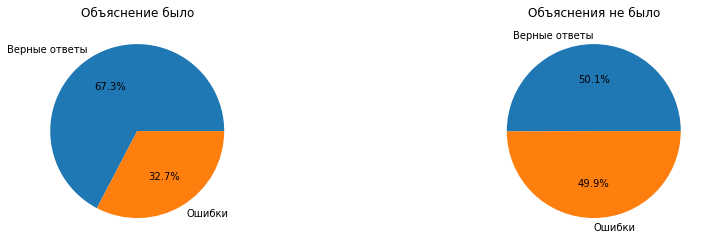

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

had_exp_true = train[(train['prior_question_had_explanation'] == True) & 
                     (train['answered_correctly'] != -1)]['answered_correctly']
had_exp_true.value_counts(normalize=True).plot.pie(autopct='%1.1f%%',
                                                   ylabel="", 
                                                   labels=["Верные ответы", "Ошибки"],
                                                   ax=ax[0])

had_exp_false = train[(train['prior_question_had_explanation'] == False) & 
                       (train['answered_correctly'] != -1)]['answered_correctly']
had_exp_false.value_counts(normalize=True).plot.pie(autopct='%1.1f%%',
                                                    ylabel="",
                                                    labels=["Верные ответы", "Ошибки"],
                                                    ax=ax[1]) 

#fig.suptitle("Зависимость доли верных ответов от\nобъяснения предыдущего вопроса", fontweight='bold', size=20)
ax[0].set_title("Объяснение было")
ax[1].set_title("Объяснения не было")

Да, похоже, эта гипотеза верна

### На какие вопросы студенты чаще отвечали и какие лекции чаще просматривали

Text(0.5, 1.0, 'Лекции')

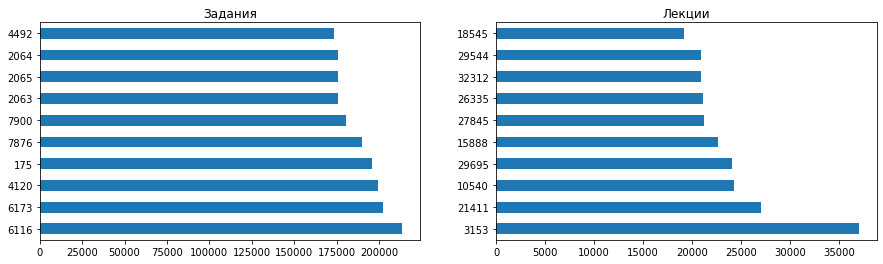

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

# возьмем только задачи, посчитаем частотности и выберем топ-10
ques = train[train['content_type_id'] == 0]['content_id'].value_counts().iloc[:10]
ques.plot.barh(ax=ax[0])


# возьмем только лекции, посчитаем частотности и выберем топ-10
ans = train[train['content_type_id'] == 1]['content_id'].value_counts().iloc[:10]
ans.plot.barh(ax=ax[1]) 

#fig.suptitle("Зависимость доли верных ответов от\nобъяснения предыдущего вопроса", fontweight='bold', size=20)
ax[0].set_title("Задания")
ax[1].set_title("Лекции")

- вообще, отвечают на задания студенты существенно чаще, чем просматривают лекции

### В каких вопросах чаще ошибались/не ошибались

Text(0.5, 1.0, 'Ошибочные ответы')

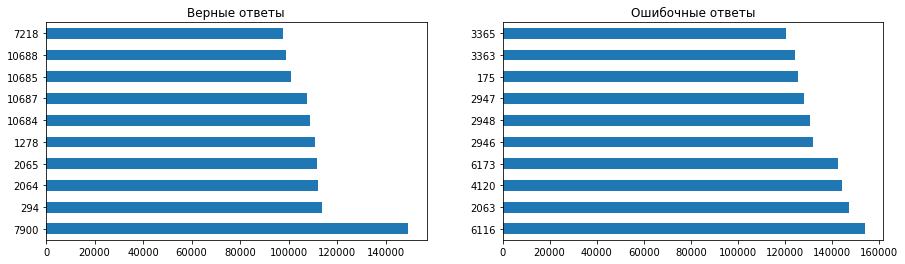

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

# выберем вопросы, на которые давали верные ответы
correct_answered = train[(train['content_type_id'] == 0) & (train['answered_correctly'] == 1)]

# выберем топ-10 вопросов, на которые чаще всего давали правильные ответы
correct_answered['content_id'].value_counts().iloc[:10].plot.barh(ax=ax[0])


# выберем вопросы, на которые давали ошибочные ответы
incorrect_answered = train[(train['content_type_id'] == 0) & (train['answered_correctly'] == 0)]

# выберем топ-10 вопросов, в которых чаще всего ошибались
incorrect_answered['content_id'].value_counts().iloc[:10].plot.barh(ax=ax[1]) 

#fig.suptitle("Зависимость доли верных ответов от\nобъяснения предыдущего вопроса", fontweight='bold', size=20)
ax[0].set_title("Верные ответы")
ax[1].set_title("Ошибочные ответы")

- Вопросы с id **7900** (топ-1 в верных ответах) и **6116** (топ-1 в ошибочных ответах) оба встречаются в топе вопросов, на которые студенты отвечали
- Вопрос **6116** и топ-1 среди частых ответов, и топ-1 среди частых ошибок
- В целом, похоже, студенты чаще ошибаются6 чем дают верные ответы

Посмотрим еще пересечения среди частых ответов и частых **правильных** ответов

In [ ]:
set(ques.index) & set(correct_answered['content_id'].value_counts().iloc[:10].index)

{2064, 2065, 7900}

И среди частых ответов и частых **ошибочных** ответов

In [ ]:
set(ques.index) & set(incorrect_answered['content_id'].value_counts().iloc[:10].index)

{175, 2063, 4120, 6116, 6173}

- Наиболее частые ошибочные ответы составляют половину топа самых частых ответов

## Сгруппируем по студентам

Проанализируем следующие разрезы:
- кол-во просмотренных лекций/успеваемость
- соответствие юзер/доля правильных ответов

Будем анализировать именно долю правильных ответов

Создадим матрицу со следующими столбцами:
- студент, 
- доля правильных ответов, 
- кол-во просмотренных лекций, 
- среднее время1 и среднее время2

In [ ]:
pivot = pd.pivot_table(train, 
               index='user_id',
               values=['answered_correctly', 'content_type_id', 'timestamp', 'prior_question_elapsed_time'],
               aggfunc={'answered_correctly': [ # доля правильных ответов, ислючая лекции 
                                               lambda x: np.sum(np.where(x==1,x, 0)) / np.sum(np.where(x!=-1,1, 0))
                                              ],
                        'content_type_id': np.sum,
                        'timestamp': np.mean,
                        'prior_question_elapsed_time': np.mean
                       }
              )

pivot = pd.DataFrame({"percentage_of_correct": pivot["answered_correctly"]["<lambda>"],
              "amount_of_lects": pivot["content_type_id"]["sum"],
              "mean_prior_time": pivot["prior_question_elapsed_time"]["mean"],
              "mean_timestamp": pivot["timestamp"]["mean"],
             })

pivot

,percentage_of_correct,amount_of_lects,mean_prior_time,mean_timestamp
user_id,,,,
115,0.695652,0,19933.311111,1.021248e+08
124,0.233333,0,18793.000000,3.678599e+05
2746,0.578947,1,18055.555556,3.831790e+05
5382,0.672000,3,36048.387097,3.801312e+08
8623,0.642202,3,26107.407407,3.479882e+08
...,...,...,...,...
2147470770,0.765487,2,23167.382222,1.145336e+09
2147470777,0.691489,6,20028.103862,1.140314e+10
2147481750,0.760000,0,17938.775510,2.195088e+07


### Распределение по количествам лекций

In [ ]:
pivot["amount_of_lects"].value_counts()

0      244050
1       39154
2       18909
3       11736
4        8564
        ...  
389         1
287         1
244         1
237         1
331         1
Name: amount_of_lects, Length: 293, dtype: int64

- Больше 60% (244050 человек) людей не посмотрели ни одной лекции
- Никто не просмотрел абсолютно все лекции (всего лекций 418, это можно увидеть в разделе lectures - лекции)


### Зависимость доли правильных ответов от количества просмотренных лекций

<AxesSubplot:xlabel='amount_of_lects', ylabel='percentage_of_correct'>

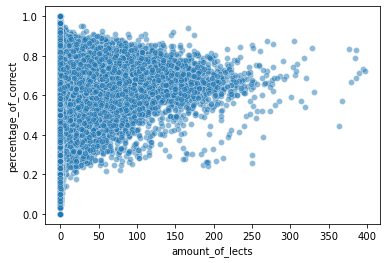

In [ ]:
sns.scatterplot(data=pivot, x="amount_of_lects", y="percentage_of_correct", alpha=0.5)

- У большинства из тех, кто просмотрел больше 0 лекций доля правильных ответов выше 20% (остальное похоже на выбросы)
- Общая тендеция такова: чем больше просмотрено лекций, тем выше доля правильных ответов, однако есть выбросы
- Cреди тех, кто посмотрел хотя бы одну лекцию успеваемость в основном выше 50%

### Данных очень много, объединим их в категории

In [ ]:
def get_cat(x):
    if x <= 5:
        return "0-5"
    elif x <= 10:
        return "6-10"
    elif x <= 50:
        return "11-50"
    elif x <= 100:
        return "51-100"
    else: 
        return "151-"

pivot["lects_amount_cat"] = pivot["amount_of_lects"].apply(lambda x: get_cat(x))

In [ ]:
pivot["lects_amount_cat"].value_counts()

0-5       329037
11-50      35581
6-10       19975
51-100      6617
151-        2446
Name: lects_amount_cat, dtype: int64

In [ ]:
sorted_lects_amount_cat = pivot["lects_amount_cat"].value_counts().sort_values(ascending=False)

In [ ]:
sorted_lects_amount_cat

0-5       329037
11-50      35581
6-10       19975
51-100      6617
151-        2446
Name: lects_amount_cat, dtype: int64

<AxesSubplot:xlabel='lects_amount_cat', ylabel='percentage_of_correct'>

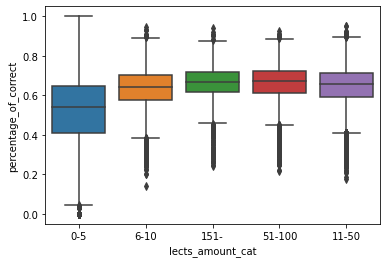

In [ ]:
sns.boxplot(data=pivot, x="lects_amount_cat", y="percentage_of_correct")

- С ростом количества просмотренных лекций растет средняя доля правильных ответов

# questions - задания

- **question_id:** связка для content_id column в train
- **bundle_id:** код вопроса, с которым задаются вместе(?) code for which questions are served together. 
- **correct_answer:** правильный ответ 
- **part:** соответствующий раздел теста TOEIC - будем считать, что это модули
- **tags:** теги вопросов

In [ ]:
questions = pd.read_csv("riiid-test-answer-prediction/questions.csv")

In [ ]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [ ]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [ ]:
questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


в каких question_id чаще ошибались? в каких part чаще ошибались? в каких tags чаще ошибались? 

### Уникальны ли question_id?

In [ ]:
len(questions['question_id'].unique())

13523

- Да

### Распредление по модулям

1. Общее распределение по модулям

In [ ]:
questions["part"].value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

- больше всего вопросов в модуле 5

2. Распределение по модулям в топе отвечаемых вопросов

In [ ]:
questions[questions["question_id"].isin(ques.index)]['part'].value_counts()

5    4
1    3
3    3
Name: part, dtype: int64

- Чаще всего отвечают на вопросы из модуля 5 (понятно, это самый объемный модуль)
- На втором месте вопросы из модуля 1 и 3

### Составим матрицу question_id/tag

1. Получим полный список тегов

In [ ]:
tags = set()
questions['tags'].apply(lambda x: tags.add(str(x)) if isinstance(x, float) else tags.update(x.split()))

tags.remove('nan')
len(tags) # всего 188 тегов

188

2. Получим список колонок

In [ ]:
columns = ['question_id'] + list(tags)

3. Шаблон для матрицы (пока теги заполним нулями)

In [ ]:
matrix = pd.DataFrame({'question_id': questions['question_id']}, columns=columns).fillna(0)
matrix.set_index('question_id', inplace=True)
matrix

,29,109,52,45,120,20,72,163,76,49,...,41,10,114,179,11,160,50,135,65,85
question_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4. Поставим 1 на пересечении тега и вопроса, если этот вопрос принадлежит этому тегу

In [ ]:
for q_id in matrix.index:
    q_tags = questions[questions['question_id'] == q_id]['tags'].iloc[0]
    if isinstance(q_tags, float):
        if np.isnan(float(q_tags)):
            continue
        matrix.loc[q_id, str(q_tags)] += 1
    else:
        tags_in_row = q_tags.split() 
        for tg in tags_in_row:
            matrix.loc[q_id, tg] += 1

### Какие теги чаще всего используются в вопросах?

In [ ]:
matrix.sum(axis=0).sort_values(ascending=False)

92     2269
38     2256
81     1969
29     1707
136    1033
       ... 
34        6
121       5
63        5
186       3
86        1
Length: 188, dtype: int64

- большинство вопросов имеют тег 92, затем 38, 81

### Какие теги имеют вопросы, на которые чаще всего отвечают? 

In [ ]:
matrix.loc[ques.index].sum(axis=0).sort_values(ascending=False).iloc[:5]

92     5
29     3
136    2
10     2
123    1
dtype: int64

- Вопросы, на которые отвечают чаще всего чаще всего имеют тег 92 (5 раз)

### Чаще всего отвечают верно?

In [ ]:
correct_answered_inds = correct_answered['content_id'].value_counts().iloc[:10]
matrix.loc[correct_answered_inds.index].sum(axis=0).sort_values(ascending=False).iloc[:5]

29     5
92     5
81     5
137    4
142    4
dtype: int64

- чаще всего 29, 92 и 81 тег имеют вопросы, на которые ответили правильно

### Чаще всего ошибаются?

In [ ]:
incorrect_answered_inds = incorrect_answered['content_id'].value_counts().iloc[:10]
matrix.loc[incorrect_answered_inds.index].sum(axis=0).sort_values(ascending=False).iloc[:5]

92     5
136    4
29     3
67     3
103    2
dtype: int64

- чаще всего 92 тег имеют вопросы, на которые ответили неправильно
- 92 тег встречается во всех топах. Можно внимательнее изучить вопросы с ним

### Всегда ли question_id и bundle_id одинаковы?

In [ ]:
# выберем вопросы, в которых question_id и bundle_id имеют разные значения
questions[questions['question_id'] != questions['bundle_id']]

,question_id,bundle_id,correct_answer,part,tags
1401,1401,1400,0,3,136 92 102
1402,1402,1400,1,3,82 92 102
1404,1404,1403,0,3,136 38 29
1405,1405,1403,3,3,82 38 29
1407,1407,1406,3,3,136 38 102
...,...,...,...,...,...
13246,13246,13244,1,3,136 81 92
13248,13248,13247,2,3,136 81 92
13249,13249,13247,1,3,136 81 92
13251,13251,13250,2,3,136 81 92


Нет 

# lectures - лекции

- **lecture_id:** связка для content_id column в train (если лекция content_type_id = 1)
- **part:** код категории верхнего уровня для лекции. Будем считать, что это номер модуля
- **tag:** единственный тег лекции
- **type_of:** краткое описание основной цели лекции.

In [ ]:
lectures = pd.read_csv("riiid-test-answer-prediction/lectures.csv")

In [ ]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [ ]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [ ]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


### Типы лекций, модули и теги

1. Посмотрим, какие типы лекции представлены в датасете

In [ ]:
lectures['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

2. Посмотрим, как модули представлены в датасете

In [ ]:
lectures['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

3. Посмотрим, топ-10 тегов

In [ ]:
lectures['tag'].value_counts().iloc[:10]

136    7
27     6
161    6
74     6
134    6
116    6
113    6
62     6
114    5
70     5
Name: tag, dtype: int64

### Типы, модули и теги в топе просматрвиаемых

In [ ]:
lectures[lectures['lecture_id'].isin(ans.index)]

,lecture_id,tag,part,type_of
38,3153,62,2,intention
125,10540,99,1,concept
190,15888,26,5,concept
227,18545,58,5,concept
262,21411,163,2,solving question
326,26335,170,5,concept
351,27845,108,5,concept
367,29544,30,2,concept
372,29695,27,6,concept
411,32312,176,2,concept


- 8 из 10 лекций имеют тип concept 
- большинство из модулей 2 и 5